In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
from fvm_utils import *
import torch

print(torch.cuda.is_available())

True


# Hybrid parameter estimation: linear regression and neural networks

Inspired by some scribbles on a Zoom whiteboard with Danny Seara, see below

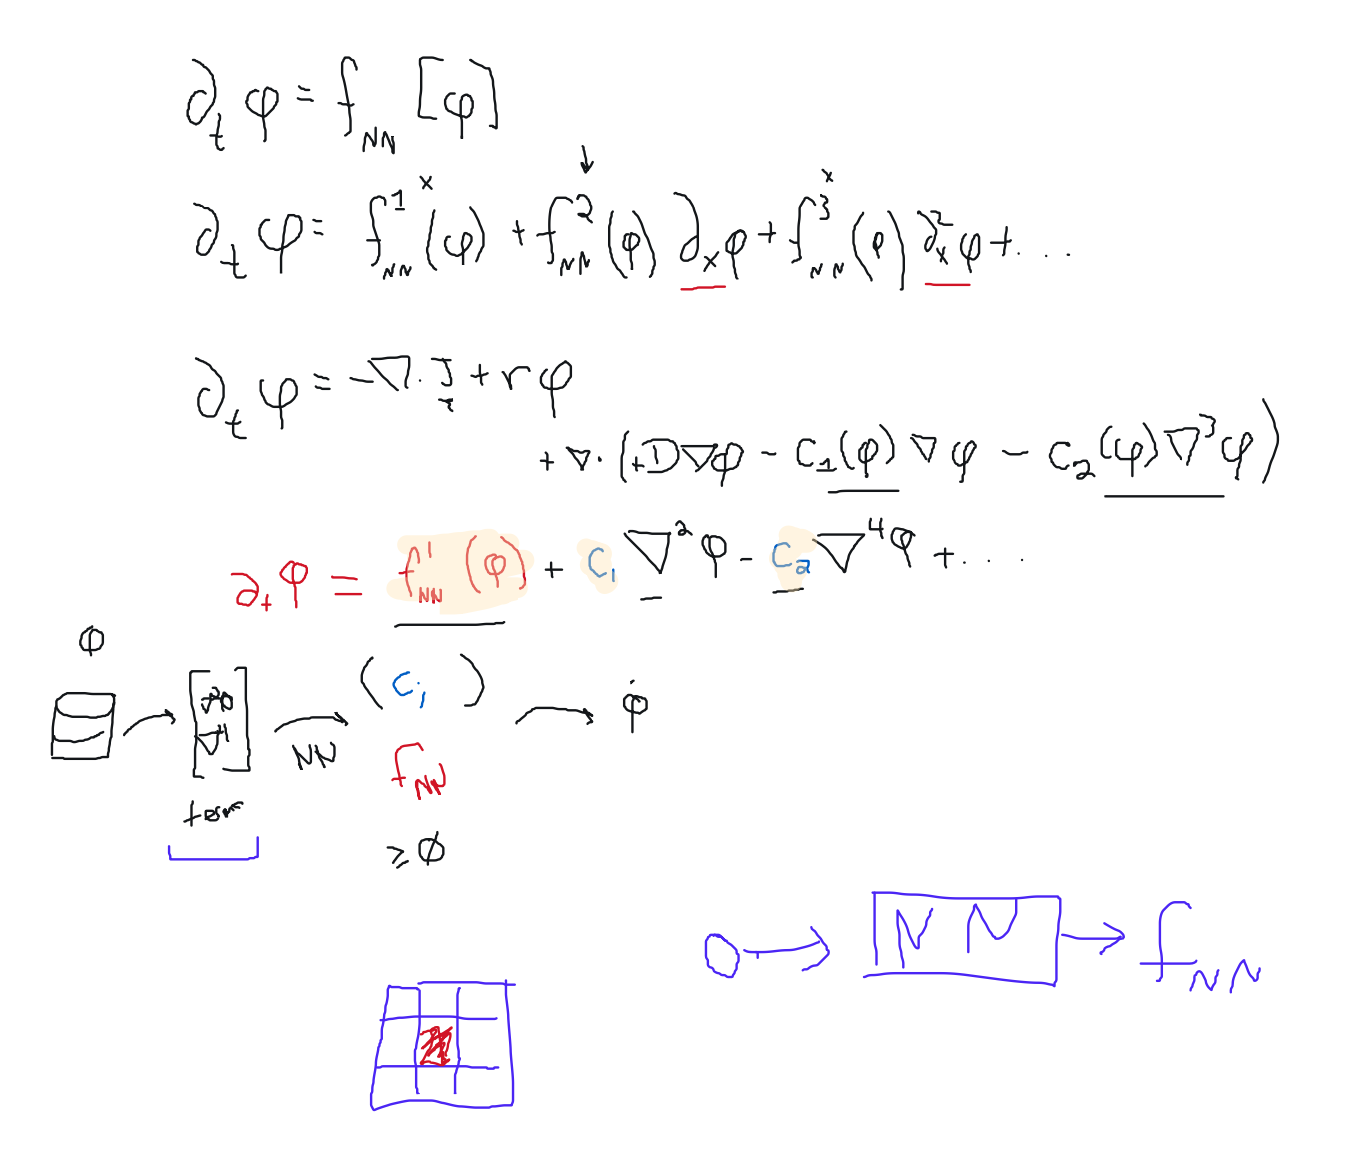

270


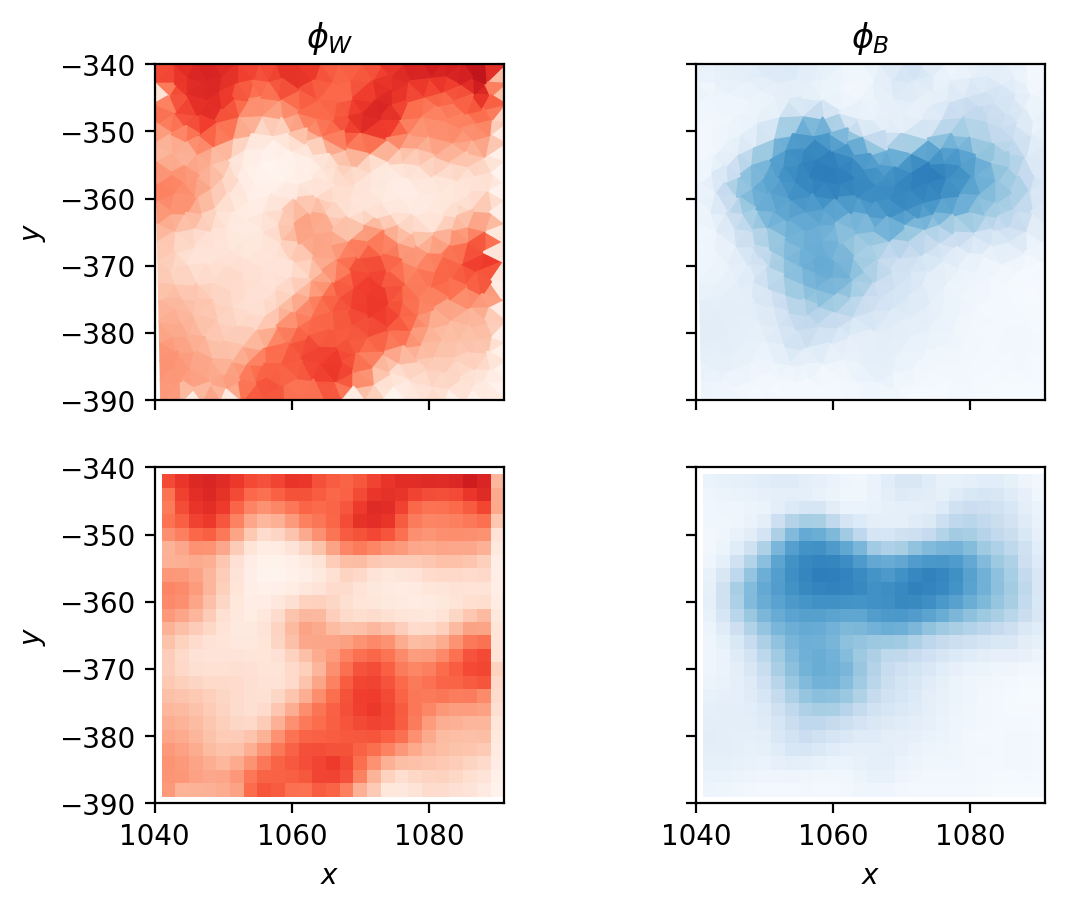

In [4]:
from fipy_dataset import FipyDataset

dataset = FipyDataset(grid=True)
print(len(dataset))
sample = dataset[5]

# Plot everything to make sure that things look correct
from fvm_utils import plot_mesh
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)

# Plot original fipy objects
plot_mesh(sample['W0_mesh'], sample['W0_mesh'].mesh, ax[0, 0], cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0, 1], cmap=plt.cm.Blues, vmin=0, vmax=1)

# Plot 
try:
    ax[1, 0].pcolormesh(sample['X'], sample['Y'], sample['W0'], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].pcolormesh(sample['X'], sample['Y'], sample['B0'], cmap='Blues', vmin=0, vmax=1)
except:
    ax[1, 0].scatter(sample['X'], sample['Y'], c=sample['W0'], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].scatter(sample['X'], sample['Y'], c=sample['B0'], cmap='Blues', vmin=0, vmax=1)

ax[0, 0].set_title('$\\phi_W$')
ax[0, 1].set_title('$\\phi_B$')

ax[0, 0].set_ylabel('$y$')
ax[1, 0].set(xlabel='$x$', ylabel='$y$')
ax[1, 1].set_xlabel('$x$')

for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_ylim()) / np.ptp(a.get_xlim()))